In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
n = 100
L_f = 1

In [3]:
# Objective function.
def f(x):
    x = np.array(x)
    s = np.sum((x[:-1] - x[1:])**2)
    return (L_f/8)*(x[0]**2 + s + x[-1]**2) - (L_f/4)*x[0]
  
# Exact Gradient of the objective function   
def grad_f(x):
    df_x1 = (L_f/4)*(2*x[0]-x[1] - 1) 
    df_xi = [(L_f/4)*(-x[i-1] + 2*x[i] - x[i+1]) for i in range(1,n-1)]
    df_xn = (L_f/4)*(2*x[-1] - x[n-2])
    return np.array([df_x1] + df_xi + [df_xn]) 

f_star = (-n*L_f)/(8*(n+1))
x_star = np.array([1-((i+1)/(n+1))  for i in range(n)])

In [4]:
# Relative noisy gradient
def noisy_gradf(x, eps):
    exact_grad = grad_f(x)
    return np.multiply(1-eps, exact_grad)

In [5]:
# ISTM
def Noise_Sim_Tri_Method(init_point, K,  Lip_cons, a, eps, p):
    fxk_Sim_Tri_Method = [f(init_point)]
    R0_squre = np.linalg.norm(x0 - x_star)**2 
    e_0 = (4*a*L_f*R0_squre)
    Estimates = [e_0]    
    y = init_point
    z = init_point
    alpha =  0   
    A = alpha           
    k = 0
    while(True):
        alpha = (k+2)**(p-1)/(2*a*Lip_cons)                      
        A1 = A + alpha                                                
        x1 = np.divide(np.multiply(alpha, z) + np.multiply(A, y) , A1 )
        z1 = np.subtract(z , np.multiply(alpha , noisy_gradf(x1, eps)))    
        y1 = np.divide(np.multiply(alpha, z1) + np.multiply(A, y) , A1)    
        y = y1
        z = z1
        A = A1              
        fxk_Sim_Tri_Method.append(f(y1))   
        k += 1          
        if not( k < K):
            break                 
        Estimate_k = 4*a*L_f*R0_squre/((k+1)**p)
        Estimates.append(Estimate_k)
    return fxk_Sim_Tri_Method, Estimates

In [6]:
# AIM, fixed p
def adaptive_L_interm_grad_inex(x0, K, p, Ls, epsilon, cons_inex):
    L = Ls 
    zk = x0
    xk = x0 
    delta0 = (epsilon**2)*((np.linalg.norm(noisy_gradf(x0, epsilon)))**2) / cons_inex
    grad_xk = noisy_gradf(xk, epsilon)
    trig = 0
    while trig<1:
        ak = 1/L
        yk = xk - np.multiply(ak, noisy_gradf(xk, epsilon))
        if (f(yk) > f(xk) + grad_xk.dot(yk-xk) + (L/2)*np.linalg.norm(yk-xk) + delta0):
            L = L*2
            trig = 0
        else:
            trig = 1 
    ak = 1/L
    Ak = ak  
    Bk = Ak    
    R0_squre = np.linalg.norm(x0 - x_star)**2  
    FxkArray = [f(yk)]
    e_0 = (8*L_f*R0_squre)/(2**p)
    Estimates1 = [e_0]   
    list_deltas = [delta0]
    Bi_deltai = Bk*delta0
    adap_estimates = []
    sums = np.multiply(ak, noisy_gradf(x0, epsilon))
    k = 0
    while(k < K):
        k += 1
        i = 0                       
        while True:                 
            L1 = 2**(i)*L
            h = ((i+2*p)/(2*p))**(p-1)
            ak = h/L1               
            Bk = ak*h 
            g = 1/h
            xk = g*zk + (1-g)*yk
            deltak = (epsilon**2)*((np.linalg.norm(noisy_gradf(xk, epsilon)))**2) / cons_inex
            grad_xk = noisy_gradf(xk, epsilon)
            zk = xk - np.sum([sums, np.multiply(ak, grad_xk)], axis=0)
            wk = g*zk + (1-g)*yk 
            i += 1
            if not (f(wk) > f(xk) + grad_xk.dot(wk-xk) + (L1/2)*(np.linalg.norm(wk-xk)**2) + deltak):
                break
        L = L1
        Ak = Ak + ak
        yk = ((Ak - Bk) * yk + Bk * wk) / Ak
        sums = np.sum([sums, np.multiply(ak, grad_xk)], axis=0)  
        FxkArray.append(f(yk))
        list_deltas.append(deltak)
        Estimate1_k = 8*L_f*R0_squre/((k+2)**p) + 2*np.max(list_deltas)*(k**(p-1))
        Estimates1.append(Estimate1_k)
        Bi_deltai += Bk*deltak
        Estimate2_k = (0.5*R0_squre + Bi_deltai )/Ak
        adap_estimates.append(Estimate2_k)                                                
    return FxkArray, Estimates1, adap_estimates

In [7]:
# AIM with variable p
def adaptive_LP_interm_grad_inex(x0, K, Ls, epsilon, cons_inex):
    L = Ls 
    zk = x0
    xk = x0 
    delta0 = (epsilon**2)*((np.linalg.norm(noisy_gradf(x0, epsilon)))**2) / cons_inex
    grad_xk = noisy_gradf(xk, epsilon)
    trig = 0
    while trig < 1:
        ak = 1/L
        yk = xk - np.multiply(ak, noisy_gradf(xk, epsilon))
        if (f(yk) > f(xk) + grad_xk.dot(yk - xk) + (L/2)*np.linalg.norm(yk - xk) + delta0):
            L = L*2
            trig = 0
        else:
            trig = 1
    ak = 1/L 
    Ak = ak  
    Bk = Ak  
    R0_squre = np.linalg.norm(x0 - x_star)**2  
    FxkArray = [f(yk)]      
    k = 0 
    p = 2
    list_deltas = [delta0]
    e_0 = (8*L_f*R0_squre)/(2**p) 
    Estimate_k = e_0
    Estimates1 = []    
    sums = np.multiply(ak, noisy_gradf(x0, epsilon))
    while(k < K):
        i = 0                       
        while True:                 
            L1 = 2**(i)*L
            h = ((i + 2*p)/(2*p))**(p - 1)
            ak = h/L1               
            Bk = ak*h          
            g = 1/h
            xk = g*zk + (1 - g)*yk
            deltak = (epsilon**2)*((np.linalg.norm(noisy_gradf(xk, epsilon)))**2) / cons_inex
            grad_xk = noisy_gradf(xk, epsilon)
            zk = xk - np.sum([sums, np.multiply(ak, grad_xk)], axis=0)
            wk = g*zk + (1 - g)*yk
            i += 1
            if not (f(wk) > f(xk) + grad_xk.dot(wk-xk) + (L1/2)*(np.linalg.norm(wk - xk)**2) + deltak):
                break    
        L = L1
        Ak = Ak + ak
        yk = ((Ak - Bk) * yk + Bk * wk) / Ak
        sums = np.sum([sums, np.multiply(ak, grad_xk)], axis=0)  
        FxkArray.append(f(yk))
        list_deltas.append(deltak)
        Estimate1_k = (8*L_f*R0_squre/((k + 2)**p)) + 2*np.max(list_deltas)*(k**(p-1))
        if (Estimate1_k - Estimate_k > 0 and p >= 1):
            p -= 0.01        
        else:
            Estimate_k = Estimate1_k
            Estimates1.append(Estimate_k)   
        k += 1                                        
    return FxkArray, Estimates1

In [8]:
x0 = np.array([0.5]*n)
K = 50000
Ls = 0.1
cons_inex = 1000
a = 30

In [9]:
# ISTM
res_nonexact_STM_2   = Noise_Sim_Tri_Method(init_point=x0, K=K, Lip_cons=L_f, a=a, eps = 0.5 , p = 2) #eps = 0.5
res_nonexact_STM_1_7 = Noise_Sim_Tri_Method(init_point=x0, K=K, Lip_cons=L_f, a=a, eps = 0.7 , p = 2) #eps = 0.7
res_nonexact_STM_1_5 = Noise_Sim_Tri_Method(init_point=x0, K=K, Lip_cons=L_f, a=a, eps = 0.9 , p = 2) #eps = 0.9
res_nonexact_STM_1_3 = Noise_Sim_Tri_Method(init_point=x0, K=K, Lip_cons=L_f, a=a, eps = 0.99, p = 2) #eps = 0.99

In [10]:
# AIM fixed p
res_adptive_L_2_0 = adaptive_L_interm_grad_inex(x0, K, p=2, Ls=Ls, epsilon=0.5, cons_inex=cons_inex)   #eps = 0.5
res_adptive_L_1_7 = adaptive_L_interm_grad_inex(x0, K, p=2, Ls=Ls, epsilon=0.7, cons_inex=cons_inex)   #eps = 0.7
res_adptive_L_1_5 = adaptive_L_interm_grad_inex(x0, K, p=2, Ls=Ls, epsilon=0.9, cons_inex=cons_inex)   #eps = 0.9
res_adptive_L_1_3 = adaptive_L_interm_grad_inex(x0, K, p=2, Ls=Ls, epsilon=0.99, cons_inex=cons_inex)  #eps = 0.99

In [11]:
# AIM with variable p 
res_adap_LP = adaptive_LP_interm_grad_inex(x0, K, Ls=Ls, epsilon=0.99, cons_inex=cons_inex)

In [12]:
y_STM_2   = [(value_f - f_star) for value_f in res_nonexact_STM_2[0] ]    #eps = 0.5
y_STM_1_7 = [(value_f - f_star) for value_f in res_nonexact_STM_1_7[0] ]  #eps = 0.7
y_STM_1_5 = [(value_f - f_star) for value_f in res_nonexact_STM_1_5[0] ]  #eps = 0.9
y_STM_1_3 = [(value_f - f_star) for value_f in res_nonexact_STM_1_3[0] ]  #eps = 0.99

In [13]:
y_adptive_L_2_0 = [(value_f - f_star) for value_f in res_adptive_L_2_0[0] ] #eps = 0.5
y_adptive_L_1_7 = [(value_f - f_star) for value_f in res_adptive_L_1_7[0] ] #eps = 0.7
y_adptive_L_1_5 = [(value_f - f_star) for value_f in res_adptive_L_1_5[0] ] #eps = 0.9
y_adptive_L_1_3 = [(value_f - f_star) for value_f in res_adptive_L_1_3[0] ] #eps = 0.99

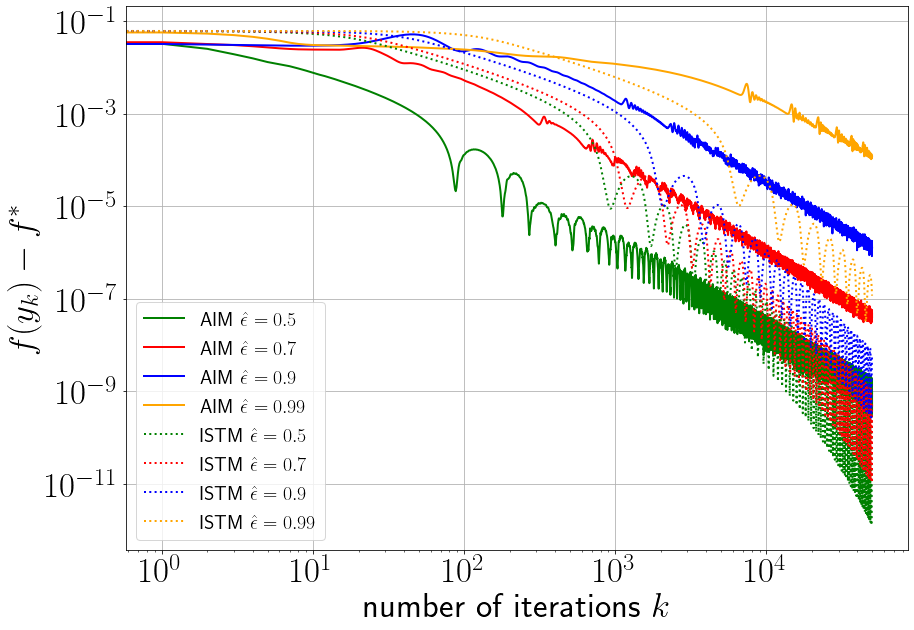

In [14]:
plt.rc('text', usetex=True)
plt.figure(figsize=(14, 10))
fontsize=20

plt.plot(range(len(y_adptive_L_2_0)), y_adptive_L_2_0, linewidth=2, label = 'AIM $\hat{\epsilon}=0.5$',  color ='g')  #eps=0.5
plt.plot(range(len(y_adptive_L_1_7)), y_adptive_L_1_7, linewidth=2, label = 'AIM $\hat{\epsilon}=0.7$',  color ='r')  #eps=0.7
plt.plot(range(len(y_adptive_L_1_5)), y_adptive_L_1_5, linewidth=2, label = 'AIM $\hat{\epsilon}=0.9$',  color ='blue')#eps=0.9 
plt.plot(range(len(y_adptive_L_1_3)), y_adptive_L_1_3, linewidth=2, label = 'AIM $\hat{\epsilon}=0.99$', color='orange')#eps=0.99 

plt.plot(range(len(y_STM_2))  , y_STM_2  , ':', linewidth=2, label = 'ISTM $\hat{\epsilon}=0.5$',  color ='g')#eps=0.5
plt.plot(range(len(y_STM_1_7)), y_STM_1_7, ':', linewidth=2, label = 'ISTM $\hat{\epsilon}=0.7$',  color ='r')#eps=0.7
plt.plot(range(len(y_STM_1_5)), y_STM_1_5, ':', linewidth=2, label = 'ISTM $\hat{\epsilon}=0.9$',  color ='blue')#eps=0.9
plt.plot(range(len(y_STM_1_3)), y_STM_1_3, ':', linewidth=2, label = 'ISTM $\hat{\epsilon}=0.99$', color ='orange')#eps=0.99

plt.grid(True)
plt.xlabel('number of iterations $k$', fontsize = 35)
plt.ylabel('$f(y_k)-f^{*}$', fontsize = 35)
plt.xticks(fontsize = 35)
_ = plt.yticks(fontsize = 35)

plt.legend(fontsize = fontsize)

#plt.title('relative error, $\hat{\epsilon}=0.9$' , fontsize=fontsize)
plt.yscale('log')
plt.xscale('log')
#plt.savefig('comparision_values_f_a30.pdf')
plt.show()

In [15]:
# estimate ISTM with p=2, eps = 0.99
estim_STM_1_3 = res_nonexact_STM_1_3[1]

In [16]:
estim_adaptive_L_1_5 = res_adptive_L_1_5[1]  # estimate for AIM  with p=2, eps = 0.9

In [17]:
estim_adaptive_LP = res_adap_LP[1]   # estimate of AIM with variable p  with eps = 0.9

In [18]:
estim2_adaptive_L_1_5 = res_adptive_L_1_5[2]  # another estimate of AIM  with p=2, eps = 0.9

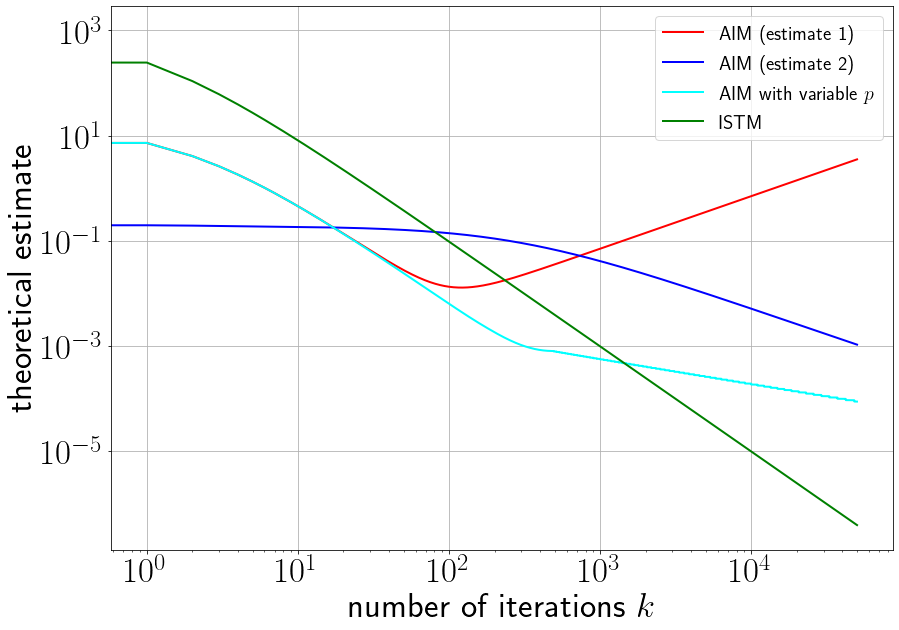

In [19]:
plt.rc('text', usetex=True)
plt.figure(figsize=(14, 10))
fontsize=20

plt.plot(range(len(estim_adaptive_L_1_5)), estim_adaptive_L_1_5, linewidth=2, label='AIM (estimate 1)', color ='r')
plt.plot(range(len(estim2_adaptive_L_1_5)), estim2_adaptive_L_1_5, linewidth=2, label='AIM (estimate 2)', color ='blue')
plt.plot(range(len(estim_adaptive_LP)), estim_adaptive_LP, linewidth=2, label = 'AIM with variable $p$', color ='cyan')
plt.plot(range(len(estim_STM_1_3)), estim_STM_1_3, linewidth=2, label = 'ISTM', color ='g')

plt.grid(True)
plt.xlabel('number of iterations $k$' , fontsize=35)
plt.ylabel('theoretical estimate' , fontsize=35)
plt.xticks(fontsize=35)
_ = plt.yticks(fontsize=35)

plt.legend(fontsize=fontsize)


#plt.title('relative error, $\hat{\epsilon}=0.9$' , fontsize=fontsize)
plt.xscale('log')
plt.yscale('log')
#plt.savefig('estimates_alg1_3_nonadaptive_a30.pdf')
plt.show()